In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import cv2
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms,models
from torch.optim.lr_scheduler import *
import copy
import random
import tqdm
from PIL import Image
import torch.nn.functional as F

%matplotlib inline

BATCH_SIZE = 20
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
cPath = os.getcwd()
train_dir = cPath + '/data/train'
test_dir = cPath + '/data/test'
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

In [3]:
class CatDogDataset(Dataset):
    def __init__(self, file_list, dir, mode='train', transform = None):
        self.file_list = file_list
        self.dir = dir
        self.mode= mode
        self.transform = transform
        if self.mode == 'train':
            if 'dog' in self.file_list[0]:
                self.label = 1
            else:
                self.label = 0
            
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.dir, self.file_list[idx]))
        if self.transform:
            img = self.transform(img)
        if self.mode == 'train':
            img = img.numpy()
            return img.astype('float32'), self.label
        else:
            img = img.numpy()
            return img.astype('float32'), self.file_list[idx]

In [4]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 先调整图片大小至256x256
    transforms.RandomCrop((224, 224)),  # 再随机裁剪到224x224
    transforms.RandomHorizontalFlip(),  # 随机的图像水平翻转，通俗讲就是图像的左右对调
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # 归一化，数值是用ImageNet给出的数值
])


cat_files = [tf for tf in train_files if 'cat' in tf]
dog_files = [tf for tf in train_files if 'dog' in tf]

cats = CatDogDataset(cat_files, train_dir, transform = train_transform)
dogs = CatDogDataset(dog_files, train_dir, transform = train_transform)

train_set = ConcatDataset([cats, dogs])
train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True, num_workers=0)

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_set = CatDogDataset(test_files, test_dir, mode='test', transform = test_transform)
test_loader = DataLoader(test_set, batch_size = BATCH_SIZE, shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


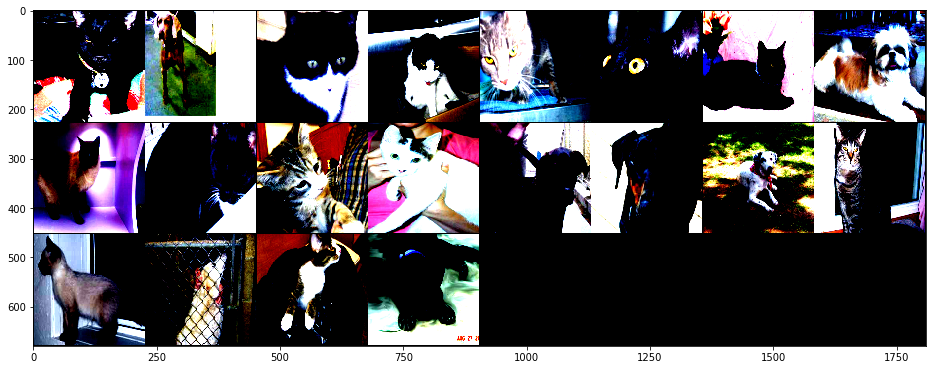

In [5]:
samples, labels = iter(train_loader).next()
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(samples[:BATCH_SIZE])
np_grid_imgs = grid_imgs.numpy()
# in tensor, image is (batch, width, height), so you have to transpose it to (width, height, batch) in numpy to show it.
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))

In [6]:
class MineNet(nn.Module):
    def __init__(self,num_classes=2):
        super().__init__()
        self.features=nn.Sequential(
            nn.Conv2d(3,64,kernel_size=11,stride=4,padding=2),   #(224+2*2-11)/4+1=55
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),   #(55-3)/2+1=27
            nn.Conv2d(64,128,kernel_size=5,stride=1,padding=2), #(27+2*2-5)/1+1=27
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),   #(27-3)/2+1=13
            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),    #(13+1*2-3)/1+1=13
            nn.ReLU(inplace=True),
            nn.Conv2d(256,128,kernel_size=3,stride=1,padding=1),    #(13+1*2-3)/1+1=13
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),    #13+1*2-3)/1+1=13
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3,stride=2),   #(13-3)/2+1=6
        )   #6*6*128=9126

        self.avgpool=nn.AdaptiveAvgPool2d((6,6))
        self.classifier=nn.Sequential(
            nn.Dropout(),
            nn.Linear(128*6*6,2048),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(2048,512),
            nn.ReLU(inplace=True),
            nn.Linear(512,num_classes),
        )
        # softmax
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self,x):
        x=self.features(x)
        x=self.avgpool(x)
        x=x.view(x.size(0),-1)
        x=self.classifier(x)
        x=self.logsoftmax(x)
        return x

In [8]:
def refreshdataloader():    
    cat_files = [tf for tf in train_files if 'cat' in tf]
    dog_files = [tf for tf in train_files if 'dog' in tf]
    
    val_cat_files = []
    val_dog_files = []
    
    for i in range(0,1250):
        r = random.randint(0,len(cat_files)-1)
        val_cat_files.append(cat_files[r])
        val_dog_files.append(dog_files[r])
        cat_files.remove(cat_files[r])
        dog_files.remove(dog_files[r])
    
    cats = CatDogDataset(cat_files, train_dir, transform = train_transform)
    dogs = CatDogDataset(dog_files, train_dir, transform = train_transform)

    train_set = ConcatDataset([cats, dogs])
    train_loader = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True, num_workers=1)
    
    val_cats = CatDogDataset(val_cat_files, train_dir, transform = test_transform)
    val_dogs = CatDogDataset(val_dog_files, train_dir, transform = test_transform)

    val_set = ConcatDataset([val_cats, val_dogs])
    val_loader = DataLoader(val_set, batch_size = BATCH_SIZE, shuffle=True, num_workers=1)
    
    return train_loader,val_loader

In [9]:
model = MineNet()
# model = MyConvNet().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)  # 设置训练细节
scheduler = StepLR(optimizer, step_size=5)
criterion = nn.CrossEntropyLoss()

In [10]:
print(model)

MineNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=4608, out_features=2048, bias=True)
 

In [12]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    percent = 10
    
    for batch_idx, (sample, target) in enumerate(train_loader):
        sample, target = sample.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(sample)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss = loss.item()
        train_loss += loss
        pred = output.max(1, keepdim = True)[1] 
        train_acc += pred.eq(target.view_as(pred)).sum().item()
            
        if (batch_idx+1)%percent == 0:
            print('train epoch: {} [{}/{} ({:.0f}%)]\tloss: {:.6f}\t'.format(
                epoch, (batch_idx+1) * len(sample), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss))
        
    train_loss *= BATCH_SIZE
    train_loss /= len(train_loader.dataset)                     
    train_acc = train_acc/len(train_loader.dataset)    
    print('\ntrain epoch: {}\tloss: {:.6f}\taccuracy:{:.4f}% '.format(epoch,train_loss,100.*train_acc))
    scheduler.step()
            
    return train_loss,train_acc

In [13]:
def val(model, device, val_loader,epoch):
    model.eval()
    val_loss =0.0
    correct = 0
    for sample, target in val_loader:
        with torch.no_grad():
            sample,target = sample.to(device),target.to(device)
            output = model(sample)
            
            val_loss += criterion(output, target).item()
            pred = output.max(1, keepdim = True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    val_loss *= BATCH_SIZE
    val_loss /= len(val_loader.dataset)
    val_acc= correct / len(val_loader.dataset)
    print("\nval set: epoch{} average loss: {:.4f}, accuracy: {}/{} ({:.4f}%) \n"
          .format(epoch, val_loss, correct, len(val_loader.dataset),100.* val_acc))
    return val_loss,100.*val_acc

In [14]:
def test(model, device, test_loader,epoch):
    model.eval()
    filename_list = []
    pred_list = []
    for sample, filename in test_loader:
        with torch.no_grad():
            sample = sample.to(device)
            output = model(sample)
            pred = torch.argmax(output, dim=1)
            
            filename_list += [n[:-4] for n in filename]
            pred_list += [p.item() for p in pred]
    
    print("\ntest epoch: {}\n".format(epoch))
    
    submission = pd.DataFrame({"id":filename_list, "label":pred_list})
    submission.to_csv('preds_' + str(epoch) + '.csv', index=False) 

In [15]:
train_losses = []
train_acces = []
val_losses = []
val_acces = []

for epoch in range(1, EPOCHS + 1):
    train_loader,val_loader = refreshdataloader()
    tr_loss,tr_acc = train(model,  DEVICE, train_loader, optimizer, epoch)
    train_losses.append(tr_loss)
    train_acces.append(tr_acc)
    
    vl,va = val(model, DEVICE, val_loader,epoch)
    val_losses.append(vl)
    val_acces.append(va)
    filename_pth = 'catdog_mineresnet_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), filename_pth)

# test(model,DEVICE,test_loader)

train epoch: 1 [200/22500 (1%)]	loss: 0.700655	
train epoch: 1 [400/22500 (2%)]	loss: 0.691462	
train epoch: 1 [600/22500 (3%)]	loss: 0.691799	
train epoch: 1 [800/22500 (3%)]	loss: 0.690561	
train epoch: 1 [1000/22500 (4%)]	loss: 0.719447	
train epoch: 1 [1200/22500 (5%)]	loss: 0.705400	
train epoch: 1 [1400/22500 (6%)]	loss: 0.698769	
train epoch: 1 [1600/22500 (7%)]	loss: 0.686727	
train epoch: 1 [1800/22500 (8%)]	loss: 0.700494	
train epoch: 1 [2000/22500 (9%)]	loss: 0.688009	
train epoch: 1 [2200/22500 (10%)]	loss: 0.672108	
train epoch: 1 [2400/22500 (11%)]	loss: 0.710217	
train epoch: 1 [2600/22500 (11%)]	loss: 0.700836	
train epoch: 1 [2800/22500 (12%)]	loss: 0.694396	
train epoch: 1 [3000/22500 (13%)]	loss: 0.682787	
train epoch: 1 [3200/22500 (14%)]	loss: 0.684351	
train epoch: 1 [3400/22500 (15%)]	loss: 0.692248	
train epoch: 1 [3600/22500 (16%)]	loss: 0.705731	
train epoch: 1 [3800/22500 (17%)]	loss: 0.692483	
train epoch: 1 [4000/22500 (18%)]	loss: 0.728006	
train epoch: 1

train epoch: 2 [10000/22500 (44%)]	loss: 0.514818	
train epoch: 2 [10200/22500 (45%)]	loss: 0.584464	
train epoch: 2 [10400/22500 (46%)]	loss: 0.646228	
train epoch: 2 [10600/22500 (47%)]	loss: 0.655753	
train epoch: 2 [10800/22500 (48%)]	loss: 0.556754	
train epoch: 2 [11000/22500 (49%)]	loss: 0.545027	
train epoch: 2 [11200/22500 (50%)]	loss: 0.594486	
train epoch: 2 [11400/22500 (51%)]	loss: 0.610791	
train epoch: 2 [11600/22500 (51%)]	loss: 0.674689	
train epoch: 2 [11800/22500 (52%)]	loss: 0.803827	
train epoch: 2 [12000/22500 (53%)]	loss: 0.555299	
train epoch: 2 [12200/22500 (54%)]	loss: 0.551427	
train epoch: 2 [12400/22500 (55%)]	loss: 0.597571	
train epoch: 2 [12600/22500 (56%)]	loss: 0.513987	
train epoch: 2 [12800/22500 (57%)]	loss: 0.645405	
train epoch: 2 [13000/22500 (58%)]	loss: 0.558527	
train epoch: 2 [13200/22500 (59%)]	loss: 0.676105	
train epoch: 2 [13400/22500 (59%)]	loss: 0.729070	
train epoch: 2 [13600/22500 (60%)]	loss: 0.525082	
train epoch: 2 [13800/22500 (61

train epoch: 3 [19600/22500 (87%)]	loss: 0.561240	
train epoch: 3 [19800/22500 (88%)]	loss: 0.517045	
train epoch: 3 [20000/22500 (89%)]	loss: 0.274046	
train epoch: 3 [20200/22500 (90%)]	loss: 0.458510	
train epoch: 3 [20400/22500 (91%)]	loss: 0.768614	
train epoch: 3 [20600/22500 (91%)]	loss: 0.541407	
train epoch: 3 [20800/22500 (92%)]	loss: 0.664521	
train epoch: 3 [21000/22500 (93%)]	loss: 0.446438	
train epoch: 3 [21200/22500 (94%)]	loss: 0.481774	
train epoch: 3 [21400/22500 (95%)]	loss: 0.399189	
train epoch: 3 [21600/22500 (96%)]	loss: 0.523438	
train epoch: 3 [21800/22500 (97%)]	loss: 0.538820	
train epoch: 3 [22000/22500 (98%)]	loss: 0.369685	
train epoch: 3 [22200/22500 (99%)]	loss: 0.371615	
train epoch: 3 [22400/22500 (99%)]	loss: 0.451398	

train epoch: 3	loss: 0.526449	accuracy:73.6000% 

val set: epoch3 average loss: 0.4520, accuracy: 1977/2500 (79.0800%) 

train epoch: 4 [200/22500 (1%)]	loss: 0.649698	
train epoch: 4 [400/22500 (2%)]	loss: 0.397799	
train epoch: 4 [6

train epoch: 5 [6400/22500 (28%)]	loss: 0.427632	
train epoch: 5 [6600/22500 (29%)]	loss: 1.107427	
train epoch: 5 [6800/22500 (30%)]	loss: 0.715615	
train epoch: 5 [7000/22500 (31%)]	loss: 0.355573	
train epoch: 5 [7200/22500 (32%)]	loss: 0.847054	
train epoch: 5 [7400/22500 (33%)]	loss: 0.557245	
train epoch: 5 [7600/22500 (34%)]	loss: 0.404331	
train epoch: 5 [7800/22500 (35%)]	loss: 0.466387	
train epoch: 5 [8000/22500 (35%)]	loss: 0.417145	
train epoch: 5 [8200/22500 (36%)]	loss: 0.241714	
train epoch: 5 [8400/22500 (37%)]	loss: 0.485918	
train epoch: 5 [8600/22500 (38%)]	loss: 0.325387	
train epoch: 5 [8800/22500 (39%)]	loss: 0.456784	
train epoch: 5 [9000/22500 (40%)]	loss: 0.353429	
train epoch: 5 [9200/22500 (41%)]	loss: 0.638427	
train epoch: 5 [9400/22500 (42%)]	loss: 0.332167	
train epoch: 5 [9600/22500 (43%)]	loss: 0.261410	
train epoch: 5 [9800/22500 (43%)]	loss: 0.535804	
train epoch: 5 [10000/22500 (44%)]	loss: 0.440755	
train epoch: 5 [10200/22500 (45%)]	loss: 0.160932

train epoch: 6 [16000/22500 (71%)]	loss: 0.137161	
train epoch: 6 [16200/22500 (72%)]	loss: 0.136381	
train epoch: 6 [16400/22500 (73%)]	loss: 0.260767	
train epoch: 6 [16600/22500 (74%)]	loss: 0.215648	
train epoch: 6 [16800/22500 (75%)]	loss: 0.224438	
train epoch: 6 [17000/22500 (75%)]	loss: 0.538979	
train epoch: 6 [17200/22500 (76%)]	loss: 0.211131	
train epoch: 6 [17400/22500 (77%)]	loss: 0.388245	
train epoch: 6 [17600/22500 (78%)]	loss: 0.352026	
train epoch: 6 [17800/22500 (79%)]	loss: 0.270525	
train epoch: 6 [18000/22500 (80%)]	loss: 0.158842	
train epoch: 6 [18200/22500 (81%)]	loss: 0.240658	
train epoch: 6 [18400/22500 (82%)]	loss: 0.219009	
train epoch: 6 [18600/22500 (83%)]	loss: 0.278841	
train epoch: 6 [18800/22500 (83%)]	loss: 0.224408	
train epoch: 6 [19000/22500 (84%)]	loss: 0.322269	
train epoch: 6 [19200/22500 (85%)]	loss: 0.205536	
train epoch: 6 [19400/22500 (86%)]	loss: 0.194447	
train epoch: 6 [19600/22500 (87%)]	loss: 0.467804	
train epoch: 6 [19800/22500 (88

train epoch: 8 [2800/22500 (12%)]	loss: 0.274111	
train epoch: 8 [3000/22500 (13%)]	loss: 0.250727	
train epoch: 8 [3200/22500 (14%)]	loss: 0.236796	
train epoch: 8 [3400/22500 (15%)]	loss: 0.138227	
train epoch: 8 [3600/22500 (16%)]	loss: 0.205136	
train epoch: 8 [3800/22500 (17%)]	loss: 0.352736	
train epoch: 8 [4000/22500 (18%)]	loss: 0.157130	
train epoch: 8 [4200/22500 (19%)]	loss: 0.067947	
train epoch: 8 [4400/22500 (19%)]	loss: 0.277437	
train epoch: 8 [4600/22500 (20%)]	loss: 0.227496	
train epoch: 8 [4800/22500 (21%)]	loss: 0.152294	
train epoch: 8 [5000/22500 (22%)]	loss: 0.075676	
train epoch: 8 [5200/22500 (23%)]	loss: 0.539509	
train epoch: 8 [5400/22500 (24%)]	loss: 0.471129	
train epoch: 8 [5600/22500 (25%)]	loss: 0.341331	
train epoch: 8 [5800/22500 (26%)]	loss: 0.227593	
train epoch: 8 [6000/22500 (27%)]	loss: 0.488418	
train epoch: 8 [6200/22500 (27%)]	loss: 0.220313	
train epoch: 8 [6400/22500 (28%)]	loss: 0.429170	
train epoch: 8 [6600/22500 (29%)]	loss: 0.173157	


train epoch: 9 [12600/22500 (56%)]	loss: 0.172973	
train epoch: 9 [12800/22500 (57%)]	loss: 0.175156	
train epoch: 9 [13000/22500 (58%)]	loss: 0.284803	
train epoch: 9 [13200/22500 (59%)]	loss: 0.265289	
train epoch: 9 [13400/22500 (59%)]	loss: 0.116913	
train epoch: 9 [13600/22500 (60%)]	loss: 0.239939	
train epoch: 9 [13800/22500 (61%)]	loss: 0.101883	
train epoch: 9 [14000/22500 (62%)]	loss: 0.248334	
train epoch: 9 [14200/22500 (63%)]	loss: 0.274966	
train epoch: 9 [14400/22500 (64%)]	loss: 0.184287	
train epoch: 9 [14600/22500 (65%)]	loss: 0.302133	
train epoch: 9 [14800/22500 (66%)]	loss: 0.104696	
train epoch: 9 [15000/22500 (67%)]	loss: 0.431757	
train epoch: 9 [15200/22500 (67%)]	loss: 0.220354	
train epoch: 9 [15400/22500 (68%)]	loss: 0.271689	
train epoch: 9 [15600/22500 (69%)]	loss: 0.260791	
train epoch: 9 [15800/22500 (70%)]	loss: 0.187165	
train epoch: 9 [16000/22500 (71%)]	loss: 0.207142	
train epoch: 9 [16200/22500 (72%)]	loss: 0.184855	
train epoch: 9 [16400/22500 (73

RuntimeError: DataLoader worker (pid(s) 2068) exited unexpectedly

In [14]:
def draw_plot(data,label,x,y):
    plt.plot(data,label=label)
    plt.xlabel(x, fontsize=14)
    plt.ylabel(y, fontsize=14)
    plt.legend()

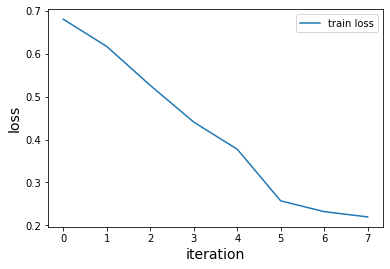

In [15]:
draw_plot(train_losses,"train loss","iteration","loss")

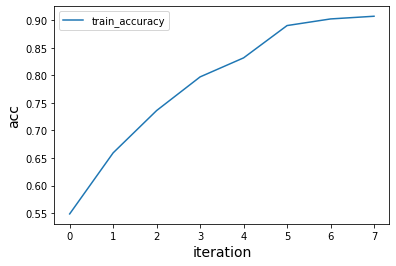

In [16]:
draw_plot(train_acces,"train_accuracy","iteration","acc")

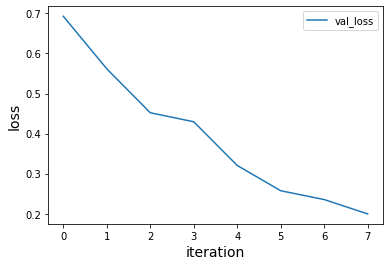

In [17]:
draw_plot(val_losses,"val_loss","iteration","loss")

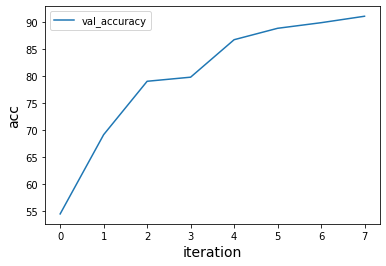

In [18]:
draw_plot(val_acces,"val_accuracy","iteration","acc")

In [11]:
model = MineNet()
model.load_state_dict(torch.load('catdog_mineresnet_8.pth'))

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

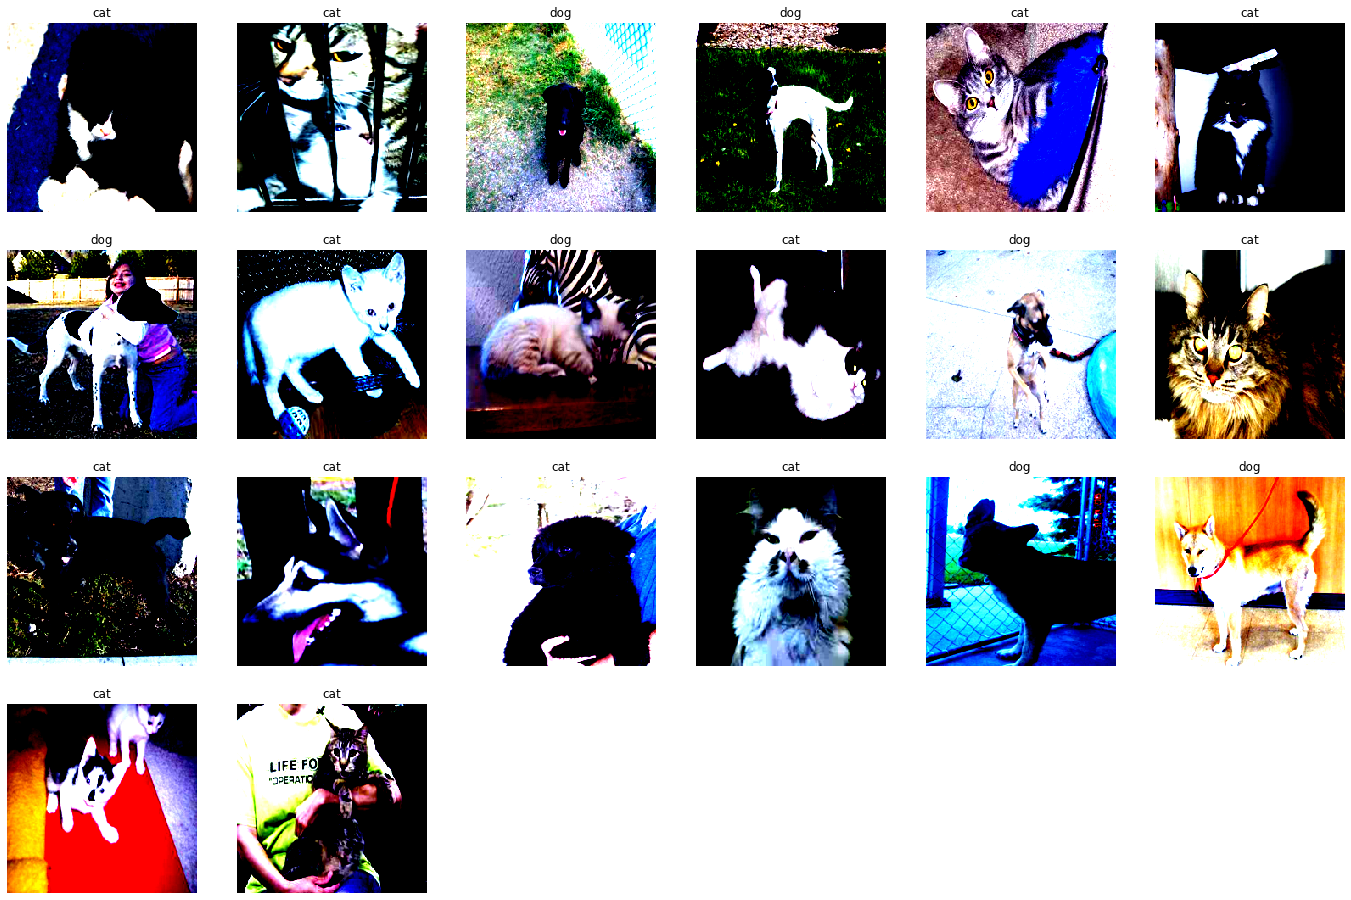

In [12]:
samples, _ = iter(test_loader).next()
samples = samples.to(DEVICE)
fig = plt.figure(figsize=(24, 16))
fig.tight_layout()
output = model(samples[:BATCH_SIZE])
pred = torch.argmax(output, dim=1)
pred = [p.item() for p in pred]
ad = {0:'cat', 1:'dog'}
for num, sample in enumerate(samples[:BATCH_SIZE]):
    plt.subplot(4,6,num+1)
    plt.title(ad[pred[num]])
    plt.axis('off')
    sample = sample.cpu().numpy()
    plt.imshow(np.transpose(sample, (1,2,0)))